In [162]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # Set default font
plt.rc('figure', figsize=(10, 10))  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_regression


In [91]:

df = pd.read_csv('./shenzhen.csv')
df.head()

,Unnamed: 0,area,title,community,position,tax,total_price,unit_price,houseType,houseSize,direction,fitment
0,0,罗湖区,满五红本， 户型方正朝南，自住装修保养好，花园社区,金城华庭,螺岭,房本满五年,710.0,79552.0,3室1厅,89.25,南,精装
1,1,罗湖区,7号线洪湖站前59万平洪湖公园后京基水贝*2个万象城,洪湖东岸,翠竹,房本满五年,408.0,54736.0,3室1厅,74.54,西,精装
2,2,罗湖区,《供电南苑。复式三层四房户型》万象城，地理位置优越,供电南苑,万象城,房本满五年,850.0,67649.0,4室1厅,125.65,西,简装
3,3,罗湖区,不用明额 满两年红本 高层东南三房 有钥匙随时可看,翡翠公寓,翠竹,房本满五年,360.0,60627.0,3室2厅,59.38,南,精装
4,4,罗湖区,都市名园 2室1厅 370万,都市名园,万象城,NaN,370.0,48259.0,2室1厅,76.67,东北,简装


In [92]:
print("Data types of each column:\n", df.dtypes)

Data types of each column:
 Unnamed: 0       int64
area            object
title           object
community       object
position        object
tax             object
total_price    float64
unit_price     float64
houseType       object
houseSize      float64
direction       object
fitment         object
dtype: object


In [93]:
# Outliers: data with room size exceeding 10,000 square meters
df[df['houseSize']>10000]

,Unnamed: 0,area,title,community,position,tax,total_price,unit_price,houseType,houseSize,direction,fitment
12546,12546,宝安区,弘雅二期花园中间，中间楼层，满五年，红本在手,弘雅花园第二期,新安,房本满五年,550.0,506.0,3室2厅,10871.0,东南,其他


In [94]:
# outliers:unit price exceeding 200,000
df[df['unit_price']>200000]

,Unnamed: 0,area,title,community,position,tax,total_price,unit_price,houseType,houseSize,direction,fitment
1121,1121,罗湖区,优质好房，空气清新，业主诚心出售,颐园,银湖,NaN,7000.0,205009.0,5室2厅,341.45,西南,精装
3002,3002,福田区,小户型，地铁口小区，满二年，纯住宅小区,金茂礼都,华强北,NaN,720.0,225635.0,1室0厅,31.91,北,精装
7752,7752,南山区,南山深圳湾，宝能太古城北，4房，高楼层，保养好,太古城北,深圳湾,NaN,1750.0,206101.0,4室1厅,84.91,西南,精装
10187,10187,宝安区,满五年，少量欠款相当于红本在手,都市翠海华苑,新安,房本满五年,455.0,207290.0,1室1厅,21.95,西北,其他


In [95]:
# delete outliers
print(len(df))
df = df.drop(df[df['houseSize']>10000].index)
df = df.drop(df[df['unit_price']>200000].index)
print(len(df))

18907
18902


In [96]:
df['tax'].unique()

array(['房本满五年', nan], dtype=object)

####  The 'area' feature already represents the location feature of the house, include 'position' and 'community' will lead to an excess of features.
####  However, the dataset can be filtered by 'area' later on to specifically study the impact of position.
####  

In [97]:
df = df.drop(columns=['title'])
df = df.drop(columns=['community'])
df = df.drop(columns=['position'])
df = df.drop(columns=['total_price'])  

# total price = size * unit price, the model will be used to predict unit price. Total price is also not a feature vector, so it will be deleted.



In [98]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [99]:
df

,area,tax,unit_price,houseType,houseSize,direction,fitment
0,罗湖区,房本满五年,79552.0,3室1厅,89.25,南,精装
1,罗湖区,房本满五年,54736.0,3室1厅,74.54,西,精装
2,罗湖区,房本满五年,67649.0,4室1厅,125.65,西,简装
3,罗湖区,房本满五年,60627.0,3室2厅,59.38,南,精装
4,罗湖区,NaN,48259.0,2室1厅,76.67,东北,简装
...,...,...,...,...,...,...,...
18902,坪山区,NaN,33265.0,4室2厅,126.26,南,其他
18903,坪山区,NaN,35560.0,1室0厅,50.62,南,简装
18904,坪山区,NaN,26031.0,1室1厅,48.02,南,精装
18905,坪山区,NaN,37838.0,1室1厅,37.00,西,精装


### Splite housetype column into 'bedroom' and 'living room'

In [100]:
df[['室','厅']] = df['houseType'].str.extract(r'(\d+)室(\d+)厅')

In [101]:
df['室'] = df['室'].astype(float)
df['厅'] = df['厅'].astype(float)
del df['houseType']
df.head()

,area,tax,unit_price,houseSize,direction,fitment,室,厅
0,罗湖区,房本满五年,79552.0,89.25,南,精装,3.0,1.0
1,罗湖区,房本满五年,54736.0,74.54,西,精装,3.0,1.0
2,罗湖区,房本满五年,67649.0,125.65,西,简装,4.0,1.0
3,罗湖区,房本满五年,60627.0,59.38,南,精装,3.0,2.0
4,罗湖区,NaN,48259.0,76.67,东北,简装,2.0,1.0


### one hot encoding

In [102]:
df['direction'].unique()

array(['南', '西', '东北', '北', '东南', '东', '西南', '东南 西北', '西北', '南 北',
       '西南 西北', '东 南', '西北 北', '东 北', '东南 西南', '北 东北', '西 北', '北 南',
       '东南 南', '南 西', '东 东南', '南 北 东北', '南 西南', '东南 东北', '东 南 北 东北',
       '东 东北', '南 东北', '西北 东北', '东北 东', '东 西', '东 南 西 北', '西南 西', '南 西 北',
       '西 东', '东 东南 北', '南 东', '西 西北', '东南 北', '东 南 北', '西南 东北', '西南 北',
       '南 西北', '东南 南 西南', '南 东南', '西北 北 东北', '东南 南 北', '东 南 西', '东 东南 南',
       '西 西南', '北 西', '东南 东', '北 东', '南 北 西', '东南 西', '东 西南', '西南 南',
       '东 西 北', '西北 东南', '西南 西 西北', '东 西北', '西 南', '东南 西 东北', '西北 西南',
       '东北 北', '东南 北 南', '西南 东南', '南 北 东南', '东南 西 西北', '东北 西南', '东 东南 东北',
       '东南 东 南', '北 西北', '东南 南 西南 北', '东南 西南 北', '西南 西北 东北', '东南 南 西北',
       '南 东 北', '西北 南', '东北 西北'], dtype=object)

In [103]:
df_direction = pd.get_dummies(df['direction'],drop_first=True)
df_direction=df_direction.astype(int)
df_direction

,东 东北,东 东南,东 东南 东北,东 东南 北,东 东南 南,东 北,东 南,东 南 北,东 南 北 东北,东 南 西,...,西北 西南,西南,西南 东北,西南 东南,西南 北,西南 南,西南 西,西南 西 西北,西南 西北,西南 西北 东北
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18904,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18905,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
df['area'].unique()

array(['罗湖区', '福田区', '南山区', '盐田区', '宝安区', '龙岗区', '龙华区', '坪山区'],
      dtype=object)

In [105]:
df_area = pd.get_dummies(df['area'],drop_first=True)
df_area=df_area.astype(int)
df_area

,坪山区,宝安区,盐田区,福田区,罗湖区,龙华区,龙岗区
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
18902,1,0,0,0,0,0,0
18903,1,0,0,0,0,0,0
18904,1,0,0,0,0,0,0
18905,1,0,0,0,0,0,0


In [106]:
df['tax'] = df['tax'].replace({'房本满五年': 1}).fillna(0)
df['tax'] = df['tax'].fillna(0).astype(int)

C:\Users\LYX\AppData\Local\Temp\ipykernel_21896\3572774232.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['tax'] = df['tax'].replace({'房本满五年': 1}).fillna(0)


In [107]:
df_fitment = pd.get_dummies(df['fitment'],drop_first=True)
df_fitment=df_fitment.astype(int)
df_fitment

,毛坯,简装,精装
0,0,0,1
1,0,0,1
2,0,1,0
3,0,0,1
4,0,1,0
...,...,...,...
18902,0,0,0
18903,0,1,0
18904,0,0,1
18905,0,0,1


In [108]:
df = pd.concat([df,df_direction,df_fitment,df_area],axis=1) 
df

,area,tax,unit_price,houseSize,direction,fitment,室,厅,东 东北,东 东南,...,毛坯,简装,精装,坪山区,宝安区,盐田区,福田区,罗湖区,龙华区,龙岗区
0,罗湖区,1,79552.0,89.25,南,精装,3.0,1.0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,罗湖区,1,54736.0,74.54,西,精装,3.0,1.0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,罗湖区,1,67649.0,125.65,西,简装,4.0,1.0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,罗湖区,1,60627.0,59.38,南,精装,3.0,2.0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,罗湖区,0,48259.0,76.67,东北,简装,2.0,1.0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18902,坪山区,0,33265.0,126.26,南,其他,4.0,2.0,0,0,...,0,0,0,1,0,0,0,0,0,0
18903,坪山区,0,35560.0,50.62,南,简装,1.0,0.0,0,0,...,0,1,0,1,0,0,0,0,0,0
18904,坪山区,0,26031.0,48.02,南,精装,1.0,1.0,0,0,...,0,0,1,1,0,0,0,0,0,0
18905,坪山区,0,37838.0,37.00,西,精装,1.0,1.0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [109]:
del df['area']
del df['direction']
del df['fitment']

In [110]:
print(df.columns.tolist())

['tax', 'unit_price', 'houseSize', '室', '厅', '东 东北', '东 东南', '东 东南 东北', '东 东南 北', '东 东南 南', '东 北', '东 南', '东 南 北', '东 南 北 东北', '东 南 西', '东 南 西 北', '东 西', '东 西 北', '东 西北', '东 西南', '东北', '东北 东', '东北 北', '东北 西北', '东北 西南', '东南', '东南 东', '东南 东 南', '东南 东北', '东南 北', '东南 北 南', '东南 南', '东南 南 北', '东南 南 西北', '东南 南 西南', '东南 南 西南 北', '东南 西', '东南 西 东北', '东南 西 西北', '东南 西北', '东南 西南', '东南 西南 北', '北', '北 东', '北 东北', '北 南', '北 西', '北 西北', '南', '南 东', '南 东 北', '南 东北', '南 东南', '南 北', '南 北 东北', '南 北 东南', '南 北 西', '南 西', '南 西 北', '南 西北', '南 西南', '西', '西 东', '西 北', '西 南', '西 西北', '西 西南', '西北', '西北 东北', '西北 东南', '西北 北', '西北 北 东北', '西北 南', '西北 西南', '西南', '西南 东北', '西南 东南', '西南 北', '西南 南', '西南 西', '西南 西 西北', '西南 西北', '西南 西北 东北', '毛坯', '简装', '精装', '坪山区', '宝安区', '盐田区', '福田区', '罗湖区', '龙华区', '龙岗区']


In [111]:
df.dropna(inplace=True)

# Multiple Linear Regression

In [245]:
cols=['tax', 'houseSize', '室', '厅', '东 东北', '东 东南', '东 东南 东北', '东 东南 北', '东 东南 南', '东 北', '东 南', 
      '东 南 北', '东 南 北 东北', '东 南 西', '东 南 西 北', '东 西', '东 西 北', '东 西北', '东 西南', '东北', '东北 东', 
      '东北 北', '东北 西北', '东北 西南', '东南', '东南 东', '东南 东 南', '东南 东北', '东南 北', '东南 北 南', '东南 南', 
      '东南 南 北', '东南 南 西北', '东南 南 西南', '东南 南 西南 北', '东南 西', '东南 西 东北', '东南 西 西北', '东南 西北', 
      '东南 西南', '东南 西南 北', '北', '北 东', '北 东北', '北 南', '北 西', '北 西北', '南', '南 东', '南 东 北', '南 东北', 
      '南 东南', '南 北', '南 北 东北', '南 北 东南', '南 北 西', '南 西', '南 西 北', '南 西北', '南 西南', '西', '西 东', '西 北',
        '西 南', '西 西北', '西 西南', '西北', '西北 东北', '西北 东南', '西北 北', '西北 北 东北', '西北 南', '西北 西南', '西南', 
        '西南 东北', '西南 东南', '西南 北', '西南 南', '西南 西', '西南 西 西北', '西南 西北', '西南 西北 东北', '毛坯', '简装', '精装', 
        '坪山区', '宝安区', '盐田区', '福田区', '罗湖区', '龙华区', '龙岗区']

In [246]:
X = df[cols]
X.head()

,tax,houseSize,室,厅,东 东北,东 东南,东 东南 东北,东 东南 北,东 东南 南,东 北,...,毛坯,简装,精装,坪山区,宝安区,盐田区,福田区,罗湖区,龙华区,龙岗区
0,1,89.25,3.0,1.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,1,74.54,3.0,1.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,125.65,4.0,1.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,1,59.38,3.0,2.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,76.67,2.0,1.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [247]:
X.dtypes

tax            int32
houseSize    float64
室            float64
厅            float64
东 东北           int32
              ...   
盐田区            int32
福田区            int32
罗湖区            int32
龙华区            int32
龙岗区            int32
Length: 92, dtype: object

In [248]:
scaler = StandardScaler()
X['houseSize'] = scaler.fit_transform(X[['houseSize']])
X.head()

C:\Users\LYX\AppData\Local\Temp\ipykernel_21896\67137007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['houseSize'] = scaler.fit_transform(X[['houseSize']])


,tax,houseSize,室,厅,东 东北,东 东南,东 东南 东北,东 东南 北,东 东南 南,东 北,...,毛坯,简装,精装,坪山区,宝安区,盐田区,福田区,罗湖区,龙华区,龙岗区
0,1,-0.195532,3.0,1.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,1,-0.461896,3.0,1.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0.463587,4.0,1.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,1,-0.736408,3.0,2.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,-0.423326,2.0,1.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [249]:
y = df[['unit_price']]
y.head()

,unit_price
0,79552.0
1,54736.0
2,67649.0
3,60627.0
4,48259.0


In [250]:
y['log_unit_price'] = np.log(y['unit_price'] + 1)
y= y.drop(columns=['unit_price'])
y.head()

C:\Users\LYX\AppData\Local\Temp\ipykernel_21896\3370747766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['log_unit_price'] = np.log(y['unit_price'] + 1)


,log_unit_price
0,11.284179
1,10.910295
2,11.122103
3,11.012512
4,10.784358


In [251]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,Feature,VIF
0,tax,2.401927
1,houseSize,2.213776
2,室,15.592831
3,厅,9.899975
4,东 东北,1.013000
...,...,...
87,盐田区,1.374316
88,福田区,1.911393
89,罗湖区,1.942675
90,龙华区,1.961254


In [252]:
threshold = 5.0  
features_to_remove = vif_data[vif_data['VIF'] > threshold]['Feature']

# Remove these features from your DataFrame
X = X.drop(columns=features_to_remove)
X


,tax,houseSize,东 东北,东 东南,东 东南 东北,东 东南 北,东 东南 南,东 北,东 南,东 南 北,...,西南 西北 东北,毛坯,简装,坪山区,宝安区,盐田区,福田区,罗湖区,龙华区,龙岗区
0,1,-0.195532,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,-0.461896,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0.463587,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,1,-0.736408,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,-0.423326,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18902,0,0.474633,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
18903,0,-0.895031,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
18904,0,-0.942111,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
18905,0,-1.141658,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [253]:
# Use SelectKBest to select the top k features based on univariate statistical tests
k_best = SelectKBest(score_func=f_regression, k=30)  # Adjust k as needed
X_new = k_best.fit_transform(X, df['unit_price'])  

# Get the selected feature names
selected_features = X.columns[k_best.get_support()]
print("Selected features:", selected_features)

Selected features: Index(['tax', 'houseSize', '东 南', '东 西', '东 西 北', '东 西北', '东北 北', '东南', '东南 南',
       '东南 南 北', '东南 南 西南 北', '东南 西北', '北', '北 西', '南 北', '南 西南', '西 北',
       '西 西南', '西北', '西南', '西南 东北', '西南 南', '简装', '坪山区', '宝安区', '盐田区', '福田区',
       '罗湖区', '龙华区', '龙岗区'],
      dtype='object')


In [254]:
new_feature = '毛坯'
selected_features = selected_features.append(pd.Index([new_feature]))

In [255]:
X= X[selected_features]
X

,tax,houseSize,东 南,东 西,东 西 北,东 西北,东北 北,东南,东南 南,东南 南 北,...,西南 南,简装,坪山区,宝安区,盐田区,福田区,罗湖区,龙华区,龙岗区,毛坯
0,1,-0.195532,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,-0.461896,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0.463587,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,1,-0.736408,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,-0.423326,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18902,0,0.474633,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
18903,0,-0.895031,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
18904,0,-0.942111,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
18905,0,-1.141658,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [256]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)

In [257]:
linear = LinearRegression()
model = linear.fit(x_train,y_train)
print(model.intercept_, model.coef_)

[11.41084237] [[-0.01255996  0.07464015  0.10666405  0.00753535  0.0943005   0.62636605
   0.29559058 -0.00205714  0.01785379  0.09595476  0.50301857  0.10875512
  -0.0029722   0.15066547  0.02009569  0.02410617  0.05545545 -0.39826842
   0.00193211  0.00559948  0.14615705 -0.34293202 -0.09817514 -0.94261891
  -0.34089767 -0.58966242 -0.14192851 -0.41340174 -0.43059623 -0.71322058
   0.01967199]]


In [258]:
y_pred = model.predict(x_test)

In [259]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 0.07166714973594833
R² Score: 0.4782145567886158


In [260]:
feature_names = X.columns
Coefficients= model.coef_

In [261]:
Coefficients

array([[-0.01255996,  0.07464015,  0.10666405,  0.00753535,  0.0943005 ,
         0.62636605,  0.29559058, -0.00205714,  0.01785379,  0.09595476,
         0.50301857,  0.10875512, -0.0029722 ,  0.15066547,  0.02009569,
         0.02410617,  0.05545545, -0.39826842,  0.00193211,  0.00559948,
         0.14615705, -0.34293202, -0.09817514, -0.94261891, -0.34089767,
        -0.58966242, -0.14192851, -0.41340174, -0.43059623, -0.71322058,
         0.01967199]])

In [262]:
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': Coefficients.flatten()})
coef_df

,Feature,Coefficient
0,tax,-0.012560
1,houseSize,0.074640
2,东 南,0.106664
3,东 西,0.007535
4,东 西 北,0.094301
5,东 西北,0.626366
6,东北 北,0.295591
7,东南,-0.002057
8,东南 南,0.017854
9,东南 南 北,0.095955


C:\Users\LYX\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


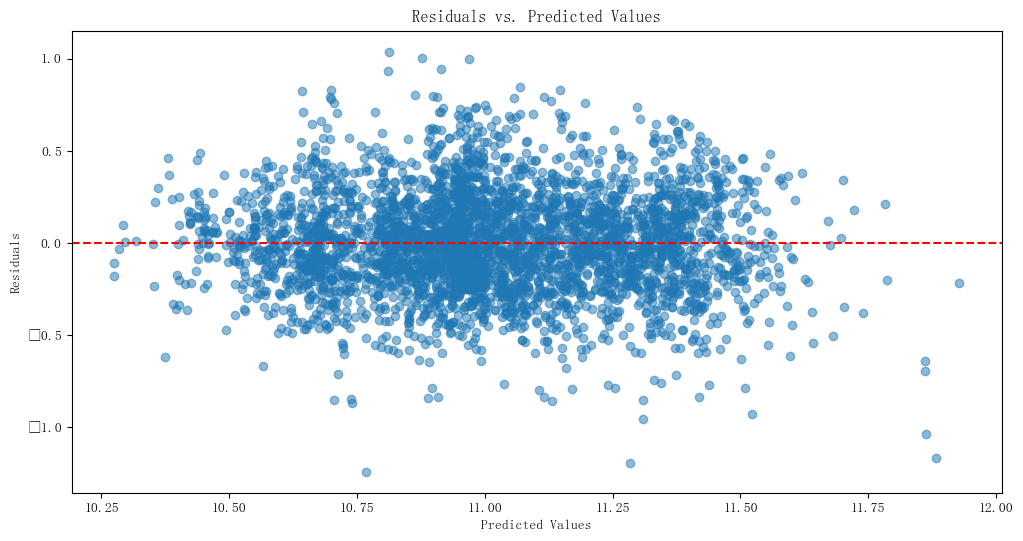

C:\Users\LYX\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


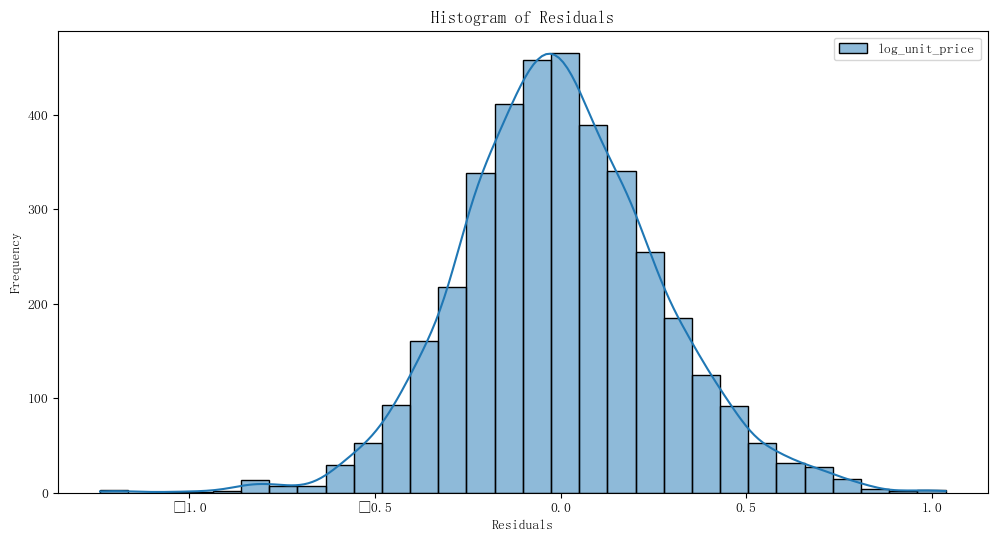

In [263]:
y_pred = model.predict(x_test)  
residuals = y_test - y_pred

# Plot residuals vs. predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

